In [2]:
import pandas as pd
import numpy as np
import networkx as nx

Reading and Pre-processing the data

In [3]:
df = pd.read_csv('dataset/Payments.csv')
bad_nodes_df = pd.read_csv('dataset/bad_sender.csv')

nodes = list(set(df['Sender']).union(set(df['Receiver'])))
nodes_dict = {node: i for i, node in enumerate(nodes)}
bad_nodes = [nodes_dict[node] for node in bad_nodes_df['Bad Sender'] if node in nodes_dict]


Creating graph, trust rank functions using NetworkX

In [4]:

def initial_trust_rank(nodes, bad_nodes):
    """
    INitializing trust rank scores for all the nodes, giving equal initial
    trust scores to bad nodes
    """
    trust_scores = np.zeros(len(nodes))
    if len(bad_nodes) > 0:
        initial_score = 1 / len(bad_nodes)
        for i in bad_nodes:
            trust_scores[i] = initial_score
    return trust_scores

def create_graph(edges_df, nodes_dict, trust_scores):
    """
    Creating a directed graph and initializing node trust scores.
    """

    G = nx.DiGraph()
    for _, row in edges_df.iterrows():
        from_node = nodes_dict[row['Sender']]
        to_node = nodes_dict[row['Receiver']]
        weight = row['Amount']
        if G.has_edge(from_node, to_node):
            G[from_node][to_node]['weight'] += weight
        else:
            G.add_edge(from_node, to_node, weight=weight)
    
    for node in G.nodes:
        G.nodes[node]['trust'] = trust_scores[node] if node in trust_scores else 0
    return G

def trust_rank(G, personalization, damping_factor=0.85):
    return nx.pagerank(G, alpha=damping_factor, personalization=personalization)


Running the Trust Rank Algorithm on our processed data

In [5]:
trust_scores = initial_trust_rank(nodes, bad_nodes)

G = create_graph(df, nodes_dict, trust_scores)

personalization = {node: trust_scores[node] for node in G.nodes}

trust_rank_scores = trust_rank(G, personalization)

print("=======================================")
print("TrustRank result:")
for node, score in sorted(trust_rank_scores.items(), key=lambda item: item[1], reverse=True):
    original_node = list(nodes_dict.keys())[list(nodes_dict.values()).index(node)]
    print(f"Node {original_node} (ID {node}): TrustRank = {score:.4f}")
print("=======================================")

TrustRank result:
Node 1007 (ID 64): TrustRank = 0.0399
Node 1088 (ID 145): TrustRank = 0.0349
Node 1144 (ID 199): TrustRank = 0.0344
Node 1210 (ID 261): TrustRank = 0.0300
Node 1042 (ID 99): TrustRank = 0.0234
Node 1086 (ID 143): TrustRank = 0.0230
Node 1034 (ID 91): TrustRank = 0.0180
Node 1076 (ID 133): TrustRank = 0.0168
Node 1048 (ID 105): TrustRank = 0.0151
Node 1099 (ID 155): TrustRank = 0.0148
Node 1147 (ID 202): TrustRank = 0.0142
Node 1205 (ID 256): TrustRank = 0.0138
Node 1626 (ID 587): TrustRank = 0.0131
Node 1201 (ID 252): TrustRank = 0.0126
Node 1011 (ID 68): TrustRank = 0.0124
Node 1094 (ID 151): TrustRank = 0.0124
Node 1173 (ID 225): TrustRank = 0.0124
Node 1480 (ID 484): TrustRank = 0.0123
Node 1013 (ID 70): TrustRank = 0.0120
Node 1084 (ID 141): TrustRank = 0.0112
Node 1122 (ID 177): TrustRank = 0.0109
Node 1161 (ID 215): TrustRank = 0.0108
Node 1489 (ID 491): TrustRank = 0.0106
Node 1836 (ID 708): TrustRank = 0.0105
Node 1041 (ID 98): TrustRank = 0.0105
Node 1259 (ID

Segregating good and bad nodes from initial data

In [6]:
import matplotlib.pyplot as plt

trust_rank_list = sorted(trust_rank_scores.items(), key=lambda item: item[1], reverse=True)

node_ids = [node[0] for node in trust_rank_list]
trust_ranks = [node[1] for node in trust_rank_list]

bad_node_ids = [node[0] for node in trust_rank_list if node[0] in bad_nodes]


In [7]:
onlyGood = list(set(node_ids) - set(bad_node_ids))
len(onlyGood), len(node_ids),len(bad_node_ids)

(779, 799, 20)

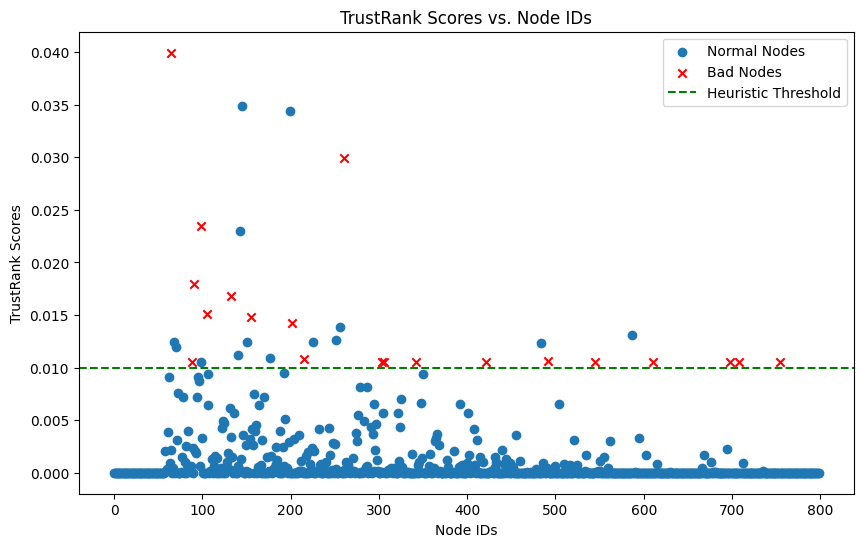

In [8]:
plt.figure(figsize=(10, 6))

plt.scatter(onlyGood, [trust_rank_scores[node_id] for node_id in onlyGood], marker='o', label='Normal Nodes')

plt.scatter(bad_node_ids, [trust_rank_scores[node_id] for node_id in bad_node_ids], marker='x', color='red', label='Bad Nodes')

plt.axhline(y=0.010, linestyle='--', color='green', label='Heuristic Threshold')

plt.title('TrustRank Scores vs. Node IDs')
plt.xlabel('Node IDs')
plt.ylabel('TrustRank Scores')

plt.legend()

From the above plot it's clear that the ranks of bad nodes provided by the oracle are generally higher than the other nodes. A heuristic thershold was also set to detect the bad / fraudulent Nodes in the graph

Text(0.5, 1.0, 'Node Counts vs Distrust Ranks')

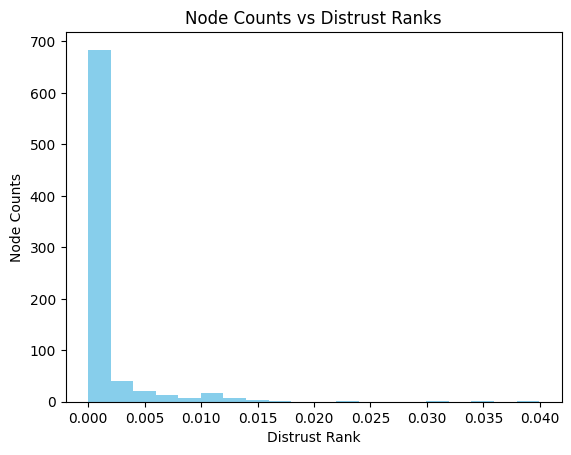

In [9]:
plt.hist(list(trust_rank_scores.values()), bins=20, color='skyblue')
plt.xlabel('Distrust Rank')
plt.ylabel('Node Counts')
plt.title('Node Counts vs Distrust Ranks')